In [59]:
import requests
import pandas           as pd
import numpy            as np
import seaborn          as sns
import yfinance         as yfin #workaround as pandas_datareader is not working on yahoo today
yfin.pdr_override()
import matplotlib.pyplot as plt

from datetime           import date, timedelta
from bs4                import BeautifulSoup
from pandas_datareader  import data as pdr
from sklearn.linear_model import LinearRegression

If you are using Anaconda, proceed as this in order to solve the SSL issue

https://github.com/conda/conda/issues/8273

# FII

In [2]:
url = "https://www.fundsexplorer.com.br/ranking"
r = requests.get(url)
df_list = pd.read_html(r.text)
df = df_list[0]
df.shape


(250, 26)

In [3]:
# Verificar quantas colunas possuem dados nulos
# df.isnull().sum()

In [4]:
df = df.replace(np.nan,0)
df = df.drop(columns=['DYPatrimonial','VariaçãoPatrimonial','Rentab. Patr.no Período',
                    'Rentab. Patr.Acumulada','VacânciaFinanceira','DY Ano','DividendYield','DY (3M)Média','DY (6M)Média',
                    'DY (3M)Acumulado',	'DY (6M)Acumulado','DY (12M)Acumulado','DY (12M)Média'])

In [5]:
dfColunas = []
naoNumColunas = ['Códigodo fundo','Setor']
for coluna in df:
    if coluna in naoNumColunas:
        pass
    else:
        dfColunas.append(coluna)       

In [6]:
for colunas in dfColunas:
    df[colunas] = [str(x).replace("R$ ","").replace("%","").replace(".","").replace(",",".") for x in df[colunas]]
    df[colunas] = [pd.to_numeric(x) for x in df[colunas]]

In [7]:
# Ajustando VPA para as cadas decimais corretas
df['P/VPA'] = df['P/VPA'] / 1000

In [8]:
def filtroDF(quantidadeAtivos=9, liquidezDiaria=1000,PVPA=1.2,VacânciaFísica=10):
# Filtrando para tirar FII's com alto risco
        # Com mais de 5 ativos. Casos menores do que esse aumentam o risco pela baixa pulverização
        dataFrame = df[(df['QuantidadeAtivos'] > quantidadeAtivos) & 
        # Liquidez diária superior a 1000
                (df['Liquidez Diária'] > liquidezDiaria) &
        # P/VPA até Máximo 1,2 (20% a mais do que o patrimonio)
                (df['P/VPA'] < PVPA) &
        # Vacância inferior a 10% do território
                (df['VacânciaFísica'] < VacânciaFísica)]
        return dataFrame
        
df = filtroDF()

In [9]:
testing = []
listingCarlos = ['BTLG11','HGRY11','VILG11','HSML11','HGBS11','XPML11','KNRI11','HGRE11','HGLG11']
for i in df['Códigodo fundo']:
    if i in listingCarlos:
        testing.append(i)
testing        

['XPML11', 'KNRI11', 'HGBS11', 'VILG11', 'HGLG11', 'BTLG11']

In [10]:
# Ordernar por critérios de maior importância (na minha opinião)
df = df.sort_values(by=['PatrimônioLíq.'], ascending = False)

# Formatar para remover Notação Científica do Patrimônio Líquido
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
df

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
90,KNRI11,Híbrido,144.99,476700,0.77,3.40,3.94,-3.99,"3,800,803,257.11",157.34,0.92,3.35,20
169,HGLG11,Logística,164.00,310310,1.10,1.35,2.02,-2.84,"3,151,358,842.72",147.86,1.11,6.30,17
119,HGRU11,Híbrido,113.00,350020,0.72,-3.13,-2.51,-7.36,"2,163,602,469.79",117.55,0.96,0.00,16
93,HGBS11,Shoppings,176.97,91650,0.85,-3.29,-2.84,-13.48,"2,143,980,697.65",214.40,0.83,7.10,17
39,XPML11,Shoppings,100.73,168650,0.57,2.02,2.59,-6.61,"1,900,090,443.88",104.36,0.97,4.60,13
116,VILG11,Logística,103.50,274340,0.64,-0.83,-0.23,-8.67,"1,708,615,548.48",113.93,0.91,0.00,15
109,VISC11,Shoppings,103.16,137170,0.58,0.59,1.16,-8.90,"1,702,561,351.78",119.30,0.86,8.10,15
108,BRCO11,Logística,100.71,191490,0.57,-3.48,-2.92,-9.47,"1,603,955,235.27",108.53,0.93,0.00,10
83,BBPO11,Lajes Corporativas,92.71,220990,0.82,-15.18,-14.46,-7.83,"1,526,344,263.71",95.88,0.97,0.00,64
248,BTLG11,Logística,106.91,401980,0.72,1.37,2.05,-4.50,"1,516,402,298.06",99.57,1.07,0.00,16


In [11]:
df['Setor'].value_counts()

Logística             7
Outros                6
Híbrido               4
Shoppings             4
Lajes Corporativas    1
Name: Setor, dtype: int64

# AÇÕES

## 1.0 Importa Histórico de Ações

In [96]:
# Cotação de cada empresa
df_ibov = pdr.get_data_yahoo("GSFI11.SA", start="2018-01-01", end=(date.today() + timedelta(days=-1) ))
df_ibov = df_ibov[['Open','Close','Volume']]
df1 = df_ibov.copy()

[*********************100%***********************]  1 of 1 completed


## 1.1 Adicionar Média Móvel de 200 dias

In [97]:
df1['MA_200'] = df1['Close'].rolling( window = 200).mean()
df1['MA_200'] = df1['MA_200'].fillna(df1['MA_200'].mean())

df1 = df1.reset_index()

## 1.2 Divisão do período treino e teste

In [102]:
train = df1[df1['Date'] <  '2021-08-01' ]
X_train = train.loc[ :, train.columns != 'Close']
y_train = train['Close']

test= df1[df1['Date'] >=  '2021-08-01' ]
X_test = test.loc[ :, test.columns != 'Close']
y_test = test['Close']

In [108]:
y_train

0     5.40
1     5.39
2     4.89
3     4.89
4     4.76
      ... 
551   5.10
552   5.07
553   5.10
554   5.10
555   5.09
Name: Close, Length: 556, dtype: float64

In [104]:
lr = LinearRegression().fit(X_train, y_train)


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>)

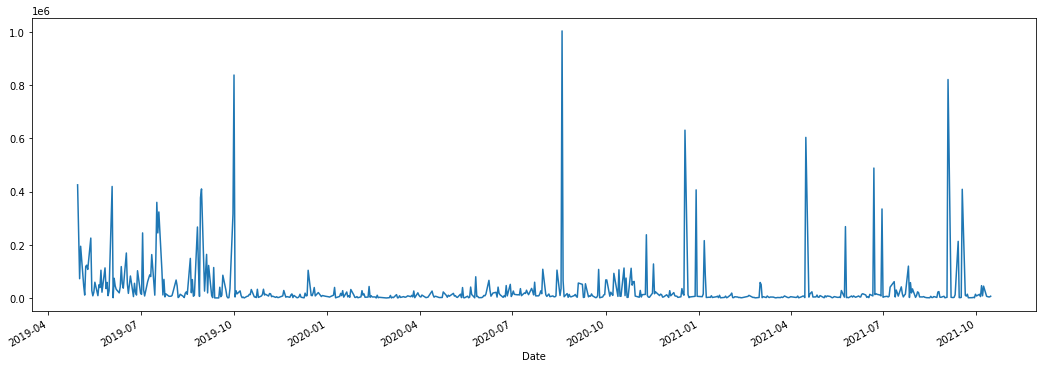

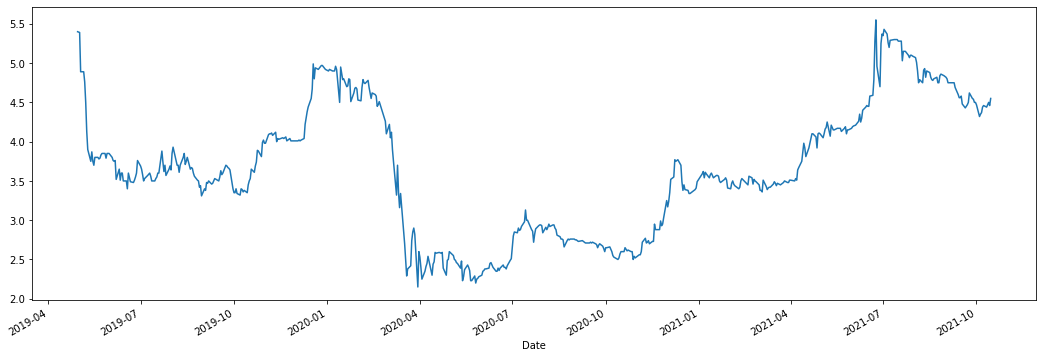

In [36]:
# plt.figure(figsize=(14,6))
plt.figure(figsize=(18,6))
df_ibov['Volume'].plot()
plt.show()

plt.figure(figsize=(18,6))
df_ibov['Close'].plot()
plt.show()



<AxesSubplot:>

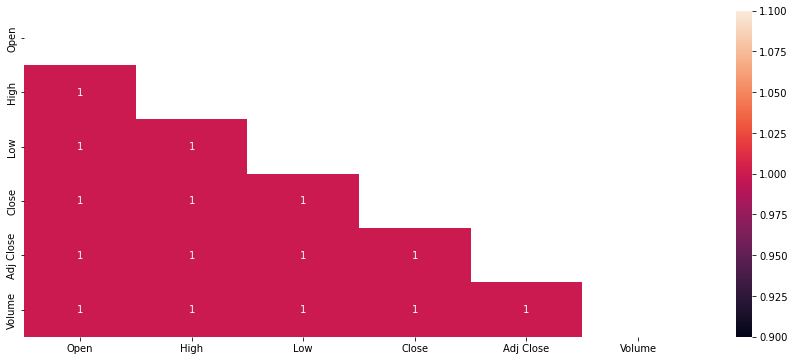

In [16]:
plt.figure(figsize=(15,6))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),annot=True, mask=mask)

In [17]:
# Criar um loop for para salvar todas as cotações em uma tabela
# Plotar adj close relativo